In [62]:
import os
from os import path
import numpy as np
import nibabel as nib
from tqdm import tqdm
from torch.utils.data import Dataset
from glob import glob
import random
import torch
import torchio as tio
import matplotlib.pyplot as plt
from dataset_tio import *
import torchvision
from generator import GeneratorRRDB
from trainer import LitTrainer as LitTrainer_conventional
import pytorch_lightning as pl

print(os.getcwd())

/mnt/beta/djboonstoppel/Code


In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(1, 224, 224, 50)
0.0
1.1494253
0.0 1.0


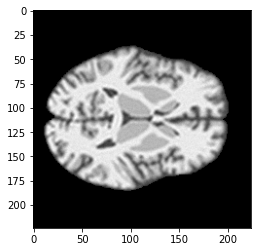

In [65]:
num = 100206
img = ImagePair(number=num, root_dir='data')
img_slice = img.subject()['LR'].numpy()[0,:,:,25]
plt.imshow(img_slice, cmap='gray')

print(img.subject()['LR'].shape)
print(img.subject()['LR'].numpy().min())
print(img.subject()['LR'].numpy().max())

min_val, max_val = np.percentile(img.subject()['LR'], (1, 99))
print(min_val, max_val)

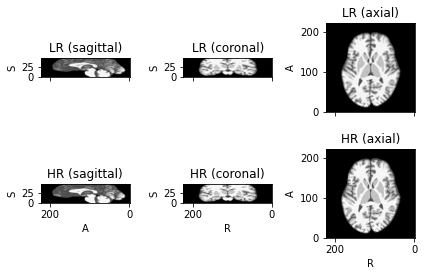

In [66]:
img.subject().plot()

In [67]:
train_subjects = data_split('training')
val_subjects = data_split('validation')
test_subjects = data_split('test')

Loading training set...
Loading validation set...
Loading test set...


In [68]:
std = 0.3548

training_transform = tio.Compose([
    Normalize(std=std),
    # tio.RandomNoise(p=0.5),
    # tio.RandomFlip(),
])

training_set = tio.SubjectsDataset(
    train_subjects, transform=training_transform)

val_set = tio.SubjectsDataset(
    val_subjects, transform=training_transform)

test_set = tio.SubjectsDataset(
    test_subjects, transform=training_transform)

In [69]:
validation_batch_size = 32

patch_size = (64,64)
ovl_perc = (.5, .5)
overlap, nr_patches = calculate_overlap(train_subjects[0]['LR'], patch_size, ovl_perc)

In [70]:
generator = GeneratorRRDB(channels=1, filters=64, num_res_blocks=1)
# discriminator = Discriminator(input_shape=(1,64,64))
# feature_extractor = FeatureExtractor().to(device)

In [71]:
model = LitTrainer_conventional.load_from_checkpoint(netG=generator, checkpoint_path="log/baseline/baseline-epoch=653.ckpt")
print(model.hparams)


"lr":  0.01
"std": 0.3548


In [72]:
subject = random.choice(test_set)
grid_sampler = tio.inference.GridSampler(
    subject,
    patch_size=(*patch_size,1),
    patch_overlap=overlap,
    padding_mode='symmetric',
)

patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)

In [119]:
model.eval()
with torch.no_grad():
    for i, patches_batch in enumerate(patch_loader):
        if i == 40:
            imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
            inputs = imgs_lr
            gen_hr = model(imgs_lr)

grid = torch.cat([torch.stack([a*std,b*std,c*std]) for a,b,c in zip(imgs_lr[:10],imgs_hr[:10],gen_hr[:10])])
grid_img = torchvision.utils.make_grid(grid, nrow=3)
plt.figure(figsize=(10,30))
plt.imshow(grid_img.permute(1, 2, 0))

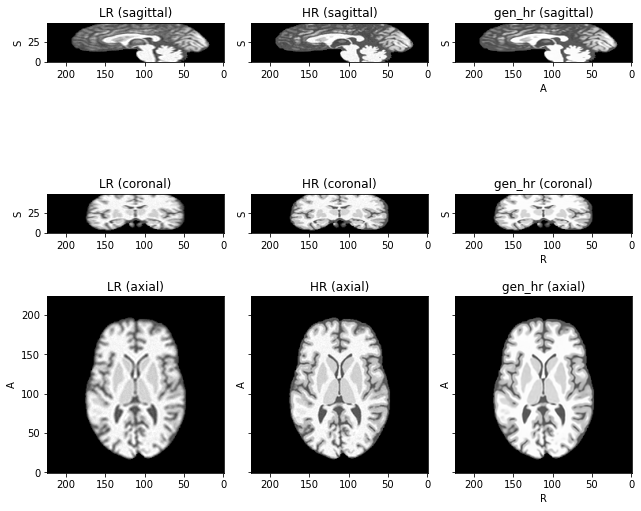

In [73]:
aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
        gen_hr = model(imgs_lr).unsqueeze(4)
        locations = patches_batch[tio.LOCATION]
        aggregator.add_batch(gen_hr, locations)

foreground = aggregator.get_output_tensor()
generated = tio.ScalarImage(tensor=foreground)
subject.add_image(generated, 'gen_hr')
subject.plot(figsize=(9, 8))

In [75]:
subject['LR'].save('output/lr.nii.gz')
subject['HR'].save('output/hr.nii.gz')
subject['gen_hr'].save('output/gen.nii.gz')